# Part 2

# Fashion-Mnist Classification

In [30]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

## load the data

In [31]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## some data information

In [32]:
train_images.shape

(60000, 28, 28)

In [33]:
test_images.shape

(10000, 28, 28)

## about the labels

In [34]:
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0: 6000,
 1: 6000,
 2: 6000,
 3: 6000,
 4: 6000,
 5: 6000,
 6: 6000,
 7: 6000,
 8: 6000,
 9: 6000}

In [35]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
dic = dict(zip(class_names, unique))
df = pd.DataFrame(dic.items())
df

,0,1
0,T-shirt/top,0
1,Trouser,1
2,Pullover,2
3,Dress,3
4,Coat,4
5,Sandal,5
6,Shirt,6
7,Sneaker,7
8,Bag,8
9,Ankle boot,9


### Lets plot images

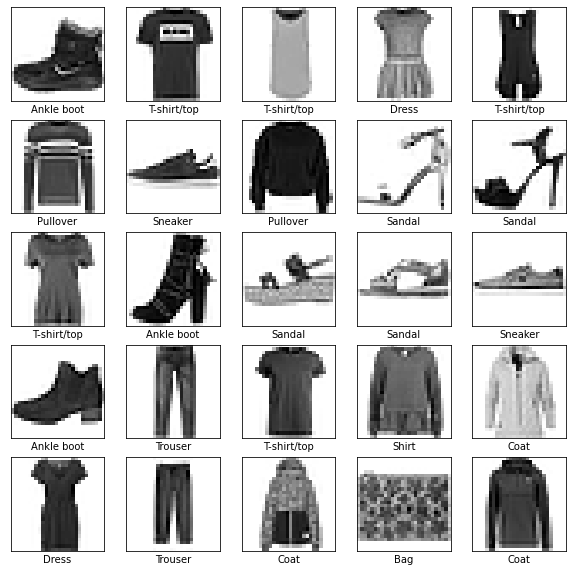

In [36]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
     
plt.show()

## PCA

Reshaping the form of the images for PCA.

In [37]:
from sklearn.decomposition import PCA

train_images = train_images.reshape(len(train_images), 28*28)
test_images = test_images.reshape(len(test_images), 28*28)

### Lets plot some sample (500) after PCA transormation

First with 3 components:

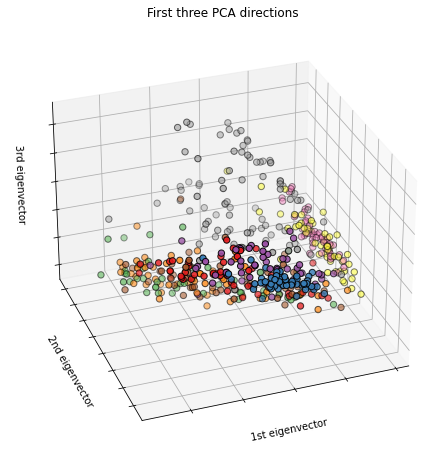

In [38]:
pca = PCA(n_components=3)

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = pca.fit_transform(train_images.reshape(len(train_images), 28*28))

ax.scatter(X_reduced[:500, 0], X_reduced[:500, 1], X_reduced[:500, 2], c=train_labels[:500],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

How many percent of the data are around the axis of the 3 components

In [39]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.29039228 0.1775531  0.06019222]
0.5281375988269682


### Lets do the same with 2 components:

([], [])

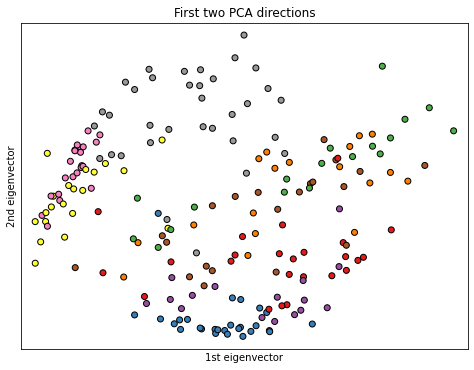

In [40]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train_images.reshape(len(train_images), 28*28))

x_min, x_max = X_reduced[:200, 0].min() - 150, X_reduced[:200, 0].max() + 150
y_min, y_max = X_reduced[:200, 1].min() - 150, X_reduced[:200, 1].max() + 150

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X_reduced[:200, 0], X_reduced[:200, 1], c=train_labels[:200], cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.title("First two PCA directions")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [41]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.29039228 0.1775531 ]
0.46794537899527855


### Finding the optimal number of components

Text(0, 0.5, 'cumulative explained variance')

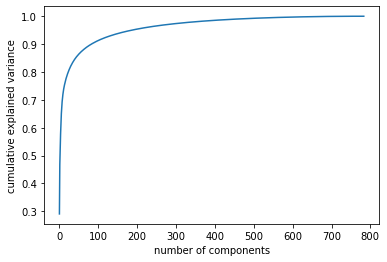

In [42]:
pca = PCA().fit(train_images.reshape(len(train_images), 28*28))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We can see that approximately after 100 components the curve no longer raise

### Lets take 100 components and fit and transform the data:

In [43]:
pca = PCA(n_components=100)

compressed_train_images = pca.fit_transform(train_images)
decompressed_train_images = pca.inverse_transform(compressed_train_images)
compressed_test_images = pca.transform(test_images)

And the result of the transformation:

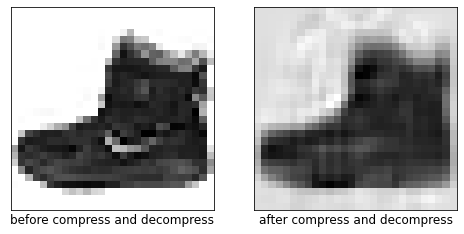

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2 ,1)   
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.xlabel('before compress and decompress', fontsize=12)
plt.imshow(train_images[0].reshape(28, 28), cmap=plt.cm.binary)

plt.subplot(1, 2, 2)   
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(decompressed_train_images[0].reshape(28, 28), cmap=plt.cm.binary)
plt.xlabel('after compress and decompress', fontsize=12)
plt.show()

# Models

#### Most of the models are training and testing first with the original data (28x28 pixels image) and after with the compressed data by PCA, the cross validation is apply on the compressed data

In [51]:
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [52]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, shuffle=True)

In [53]:
def display_scores(scores):
    print("Mean Accuracy: {:.2f}%".format(scores.mean()*100))
    print("Standard deviation: {:.2f}%".format(scores.std()*100))

In [54]:
def fit_predict(name, modle, PCA=False):
    if (PCA==True):
        modle.fit(compressed_train_images, train_labels)
        print(name, "Accuracy with PCA: {:.2f}%".format(modle.score(compressed_test_images, test_labels)*100), "\n")

        y_pred = modle.predict(compressed_test_images)
        print(name, "Matrix with PCA:\n", confusion_matrix(test_labels, y_pred), "\n")
        print("Classification Report:\n", classification_report(test_labels, y_pred))
    
    else:
        modle.fit(train_images, train_labels)
        print(name, "Accuracy: {:.2f}%".format(modle.score(test_images, test_labels)*100), "\n")

        y_pred = modle.predict(test_images)
        print(name, "Matrix:\n", confusion_matrix(test_labels, y_pred), "\n")
        print("Classification Report:\n", classification_report(test_labels, y_pred))

## KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

In [60]:
fit_predict("KNN", knn)

KNN Accuracy: 85.54% 

KNN Matrix:
 [[855   1  17  16   3   1 100   1   6   0]
 [  8 968   4  12   4   0   3   0   1   0]
 [ 24   2 819  11  75   0  69   0   0   0]
 [ 41   8  15 860  39   0  34   0   3   0]
 [  2   1 126  26 773   0  71   0   1   0]
 [  1   0   0   0   0 822   5  96   1  75]
 [176   1 132  23  80   0 575   0  13   0]
 [  0   0   0   0   0   3   0 961   0  36]
 [  2   0  10   4   7   0  16   7 953   1]
 [  0   0   0   0   0   2   1  29   0 968]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.73      0.82      0.77      1000
           3       0.90      0.86      0.88      1000
           4       0.79      0.77      0.78      1000
           5       0.99      0.82      0.90      1000
           6       0.66      0.57      0.61      1000
           7       0.88      0.96      0.92      1000
           8       0

In [61]:
fit_predict("KNN", knn, True)

KNN Accuracy with PCA: 86.28% 

KNN Matrix with PCA:
 [[841   0  15  19   5   1 108   1  10   0]
 [  7 969   3  13   4   0   3   0   1   0]
 [ 21   2 791  11  99   0  75   0   1   0]
 [ 36   6  15 874  41   0  24   0   4   0]
 [  2   2 112  24 788   0  68   0   4   0]
 [  0   0   0   0   0 894   0  59   2  45]
 [163   1 125  23  94   0 583   0  11   0]
 [  0   0   0   0   0   6   0 957   0  37]
 [  2   0   5   5   4   2  11   5 965   1]
 [  0   0   0   0   0   2   0  31   1 966]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.74      0.79      0.77      1000
           3       0.90      0.87      0.89      1000
           4       0.76      0.79      0.77      1000
           5       0.99      0.89      0.94      1000
           6       0.67      0.58      0.62      1000
           7       0.91      0.96      0.93      1000
  

In [62]:
scores = cross_val_score(knn, compressed_train_images, train_labels, cv=kf)
display_scores(scores)

Mean Accuracy: 86.34%
Standard deviation: 0.37%


## Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression

logisticRegression = LogisticRegression()

In [64]:
fit_predict("Logistic Regression", logisticRegression)

Logistic Regression Accuracy: 84.12% 

Logistic Regression Matrix:
 [[812   5  16  46   9   0  98   0  14   0]
 [  2 960   1  27   4   0   4   0   2   0]
 [ 18   6 737  11 140   1  78   0   9   0]
 [ 25  15  15 858  44   1  37   0   5   0]
 [  0   3 106  33 779   1  70   0   8   0]
 [  1   1   0   0   0 891   0  56   9  42]
 [139   3 129  42 114   0 550   0  23   0]
 [  0   0   0   0   0  36   0 933   0  31]
 [  3   1   7  10   2   3  21   5 947   1]
 [  0   0   0   0   0  13   0  39   3 945]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1000
           1       0.97      0.96      0.96      1000
           2       0.73      0.74      0.73      1000
           3       0.84      0.86      0.85      1000
           4       0.71      0.78      0.74      1000
           5       0.94      0.89      0.92      1000
           6       0.64      0.55      0.59      1000
           7       0.90      0.93      0.9

In [65]:
fit_predict("Logistic Regression", logisticRegression, True)

Logistic Regression Accuracy with PCA: 83.96% 

Logistic Regression Matrix with PCA:
 [[820   2  12  55   7   4  89   0  11   0]
 [  3 954   6  29   4   0   3   0   1   0]
 [ 21   7 725  10 135   2  88   2  10   0]
 [ 32  14   9 866  27   2  45   0   5   0]
 [  0   2 100  45 753   2  88   2   8   0]
 [  0   0   0   0   0 925   0  54   5  16]
 [142   2 129  40 115   2 545   1  24   0]
 [  0   0   0   0   0  38   0 925   0  37]
 [  6   2   7  11   3   5  19   7 937   3]
 [  0   0   0   0   0  15   0  38   1 946]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.97      0.95      0.96      1000
           2       0.73      0.72      0.73      1000
           3       0.82      0.87      0.84      1000
           4       0.72      0.75      0.74      1000
           5       0.93      0.93      0.93      1000
           6       0.62      0.55      0.58      1000
           7       0.90 

In [66]:
scores = cross_val_score(logisticRegression, compressed_train_images, train_labels, cv=kf)
display_scores(scores)

Mean Accuracy: 84.83%
Standard deviation: 0.42%


## Gaussian Naive Bayes

In [67]:
from sklearn.naive_bayes import GaussianNB

gaussianNB = GaussianNB()

In [68]:
fit_predict("Gaussian Naive Bayes", gaussianNB)

Gaussian Naive Bayes Accuracy: 58.56% 

Gaussian Naive Bayes Matrix:
 [[586  64  29 162 110   0  20   0  29   0]
 [  1 939  14  36   7   0   1   0   2   0]
 [  7  14 324  65 545   0  23   0  22   0]
 [  9 387   6 545  43   0   4   0   6   0]
 [  0  34  44 131 779   0   4   0   8   0]
 [  0   0   1   1   0 278   3 660   5  52]
 [117  34 112 200 435   0  40   0  62   0]
 [  0   0   0   0   0   3   0 988   0   9]
 [  0   2  19  85 149   3  27   4 710   1]
 [  0   0   1   1   0  16   3 304   8 667]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.59      0.68      1000
           1       0.64      0.94      0.76      1000
           2       0.59      0.32      0.42      1000
           3       0.44      0.55      0.49      1000
           4       0.38      0.78      0.51      1000
           5       0.93      0.28      0.43      1000
           6       0.32      0.04      0.07      1000
           7       0.51      0.99      0

In [69]:
fit_predict("Gaussian Naive Bayes", gaussianNB, True)

Gaussian Naive Bayes Accuracy with PCA: 75.87% 

Gaussian Naive Bayes Matrix with PCA:
 [[743   0  18  62   6   4  81   0  86   0]
 [  6 891  17  49   3   3  12   0  19   0]
 [ 17   0 618   7 121   5 164   0  68   0]
 [ 52   5  13 779  31   7  68   0  45   0]
 [  5   0 123  34 651   1 139   0  47   0]
 [  4   0   0   1   0 748  35 159  38  15]
 [163   0 106  36  77   5 518   1  94   0]
 [  1   0   0   0   0  48   2 875   1  73]
 [ 15   0   8   8   6  19  42  31 870   1]
 [  0   0   0   0   0  23   7  58  18 894]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      1000
           1       0.99      0.89      0.94      1000
           2       0.68      0.62      0.65      1000
           3       0.80      0.78      0.79      1000
           4       0.73      0.65      0.69      1000
           5       0.87      0.75      0.80      1000
           6       0.49      0.52      0.50      1000
           7       0.7

#### We can see much more better score with PCA

In [70]:
scores = cross_val_score(gaussianNB, compressed_train_images, train_labels, cv=kf)
display_scores(scores)

Mean Accuracy: 76.97%
Standard deviation: 0.54%


## Decision Tree

In [71]:
from sklearn.tree import DecisionTreeClassifier

decisionTreeClassifier = DecisionTreeClassifier()

In [72]:
fit_predict("Decision Tree", decisionTreeClassifier)

Decision Tree Accuracy: 78.53% 

Decision Tree Matrix:
 [[732   4  30  44  10   2 164   1  11   2]
 [  8 948   5  14  11   0  10   0   3   1]
 [ 19   2 641  21 160   1 140   1  11   4]
 [ 56  28  17 777  61   0  49   0  12   0]
 [ 11   4 178  46 637   0 113   0  10   1]
 [  1   2   1   1   0 877   2  57  20  39]
 [148  10 128  41 108   2 541   1  19   2]
 [  0   0   0   0   0  45   0 883   7  65]
 [ 11   6  14   3  12  12  22   8 906   6]
 [  1   0   0   0   0  24   0  60   4 911]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74      1000
           1       0.94      0.95      0.95      1000
           2       0.63      0.64      0.64      1000
           3       0.82      0.78      0.80      1000
           4       0.64      0.64      0.64      1000
           5       0.91      0.88      0.89      1000
           6       0.52      0.54      0.53      1000
           7       0.87      0.88      0.88      1000


In [73]:
fit_predict("Decision Tree", decisionTreeClassifier, True)

Decision Tree Accuracy with PCA: 76.09% 

Decision Tree Matrix with PCA:
 [[695  14  40  53  19   5 160   0  14   0]
 [ 11 931   6  32   9   0   8   0   3   0]
 [ 29   8 644  19 136   4 145   0  14   1]
 [ 50  43  24 772  54   4  42   0  11   0]
 [ 10   5 175  42 634   2 117   0  14   1]
 [  4   1   1   4   2 819   1  97  15  56]
 [158   9 118  46 126   5 512   1  24   1]
 [  1   0   0   0   0  76   1 834   6  82]
 [  8   1  24  10  14  24  19   7 889   4]
 [  0   0   2   1   1  39   1  76   1 879]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.71      1000
           1       0.92      0.93      0.93      1000
           2       0.62      0.64      0.63      1000
           3       0.79      0.77      0.78      1000
           4       0.64      0.63      0.64      1000
           5       0.84      0.82      0.83      1000
           6       0.51      0.51      0.51      1000
           7       0.82      0.83   

In [74]:
scores = cross_val_score(decisionTreeClassifier, compressed_train_images, train_labels, cv=kf)
display_scores(scores)

Mean Accuracy: 76.41%
Standard deviation: 0.78%


## SVC

In [75]:
from sklearn.svm import SVC

svm = SVC()

In [76]:
fit_predict("SVC", svm)

SVC Accuracy: 88.28% 

SVC Matrix:
 [[857   0  16  28   3   2  85   0   9   0]
 [  4 962   2  25   3   0   4   0   0   0]
 [ 11   2 816  16  88   0  65   0   2   0]
 [ 27   3  11 890  33   0  32   0   4   0]
 [  1   1  87  32 815   0  61   0   3   0]
 [  0   0   0   1   0 951   0  33   1  14]
 [135   1 104  27  68   0 654   0  11   0]
 [  0   0   0   0   0  21   0 955   0  24]
 [  3   1   1   5   2   2   4   5 977   0]
 [  0   0   0   0   0  11   1  37   0 951]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.79      0.82      0.80      1000
           3       0.87      0.89      0.88      1000
           4       0.81      0.81      0.81      1000
           5       0.96      0.95      0.96      1000
           6       0.72      0.65      0.69      1000
           7       0.93      0.95      0.94      1000
           8       0

In [77]:
fit_predict("SVC", svm, True)

SVC Accuracy with PCA: 88.44% 

SVC Matrix with PCA:
 [[860   0  10  27   4   2  91   0   6   0]
 [  4 963   0  25   3   0   5   0   0   0]
 [ 12   1 804  14  96   0  72   0   1   0]
 [ 22   3  13 895  32   0  31   0   4   0]
 [  0   0  89  31 816   0  63   0   1   0]
 [  0   0   0   1   0 951   0  37   1  10]
 [132   1  94  28  66   0 666   0  13   0]
 [  0   0   0   0   0  16   0 960   0  24]
 [  3   0   1   7   3   3   3   5 975   0]
 [  0   0   0   0   0   8   1  37   0 954]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.87      0.90      0.88      1000
           4       0.80      0.82      0.81      1000
           5       0.97      0.95      0.96      1000
           6       0.71      0.67      0.69      1000
           7       0.92      0.96      0.94      1000
  

In [78]:
scores = cross_val_score(svm, compressed_train_images, train_labels, cv=kf)
display_scores(scores)

Mean Accuracy: 89.20%
Standard deviation: 0.39%


# Ensemble Learning

## Voting Classifier with: KNN , Logistic Regression and SVC

In [79]:
from sklearn.ensemble import VotingClassifier

### voting hard

In [80]:
voting_hard = VotingClassifier(estimators=[('logRegression', logisticRegression), ('knn', knn), ('svc', svm)], voting='hard')

In [81]:
fit_predict("Voting Hard", voting_hard, True)

Voting Hard Accuracy with PCA: 87.97% 

Voting Hard Matrix with PCA:
 [[868   0  10  24   3   2  85   0   8   0]
 [  5 962   2  25   3   0   3   0   0   0]
 [ 18   4 813  11  97   0  55   0   2   0]
 [ 28   3  16 895  28   0  27   0   3   0]
 [  0   1  97  31 812   0  56   0   3   0]
 [  0   0   0   1   0 944   0  38   2  15]
 [155   2 109  24  77   0 621   0  12   0]
 [  0   0   0   0   0  16   0 957   0  27]
 [  4   0   0   7   3   3   6   6 971   0]
 [  0   0   0   0   0  11   0  34   1 954]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.78      0.81      0.79      1000
           3       0.88      0.90      0.89      1000
           4       0.79      0.81      0.80      1000
           5       0.97      0.94      0.96      1000
           6       0.73      0.62      0.67      1000
           7       0.92      0.96      0

### voting soft

In [82]:
svm = SVC(probability=True)
voting_soft = VotingClassifier(estimators=[('logRegression', logisticRegression), ('knn', knn), ('svc', svm)], voting='soft')

In [83]:
fit_predict("Voting Soft", voting_soft, True)

Voting Soft Accuracy with PCA: 88.27% 

Voting Soft Matrix with PCA:
 [[860   0  11  20   4   1  92   1  11   0]
 [  4 966   3  20   3   0   3   0   1   0]
 [ 17   0 800   9 100   0  68   1   5   0]
 [ 17   4  10 903  27   1  34   0   4   0]
 [  1   0  82  32 812   0  69   0   4   0]
 [  0   0   0   0   0 946   0  37   1  16]
 [140   1  92  26  79   0 645   0  17   0]
 [  0   0   0   0   0  14   0 959   0  27]
 [  0   1   1   5   2   2  10   4 975   0]
 [  0   0   0   0   0   6   0  32   1 961]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.89      0.90      0.90      1000
           4       0.79      0.81      0.80      1000
           5       0.98      0.95      0.96      1000
           6       0.70      0.65      0.67      1000
           7       0.93      0.96      0

## Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

In [85]:
fit_predict("Random Forest", randomForest)

Random Forest Accuracy: 75.34% 

Random Forest Matrix:
 [[777   5  52 124   9   1   6   0  26   0]
 [  1 848  21 124   3   0   0   0   3   0]
 [ 13   1 685  11 274   0   2   0  14   0]
 [ 31   6  41 874  40   0   2   0   6   0]
 [  1   2 155  89 744   3   2   0   4   0]
 [  0   0   0   2   0 837   0  90   8  63]
 [215   4 213 123 366   1  36   0  42   0]
 [  0   0   0   0   0  15   0 888   1  96]
 [  3   2  38  27   4   8   0   7 911   0]
 [  0   0   0   0   0   7   0  55   4 934]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76      1000
           1       0.98      0.85      0.91      1000
           2       0.57      0.69      0.62      1000
           3       0.64      0.87      0.74      1000
           4       0.52      0.74      0.61      1000
           5       0.96      0.84      0.89      1000
           6       0.75      0.04      0.07      1000
           7       0.85      0.89      0.87      1000


In [86]:
fit_predict("Random Forest", randomForest, True)

Random Forest Accuracy with PCA: 74.35% 

Random Forest Matrix with PCA:
 [[794   4  17 100  12  29  16   0  28   0]
 [ 14 925   7  46   4   2   0   0   2   0]
 [ 46   2 643   9 180   9  65   0  46   0]
 [ 61  12   4 807  55  16  30   1  11   3]
 [  5   4 182  36 689  10  43   0  31   0]
 [  2   0   0   1  10 786   2 104  23  72]
 [275   4 165  55 195  42 202   0  61   1]
 [  2   0   0   0   2 118   0 796   7  75]
 [  9   3   6   7  10  31  11   9 912   2]
 [  0   0   1   0   1  62   1  51   3 881]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.79      0.72      1000
           1       0.97      0.93      0.95      1000
           2       0.63      0.64      0.64      1000
           3       0.76      0.81      0.78      1000
           4       0.59      0.69      0.64      1000
           5       0.71      0.79      0.75      1000
           6       0.55      0.20      0.29      1000
           7       0.83      0.80   

#### Lets plot the pixels importance with RandomForest feature_importances

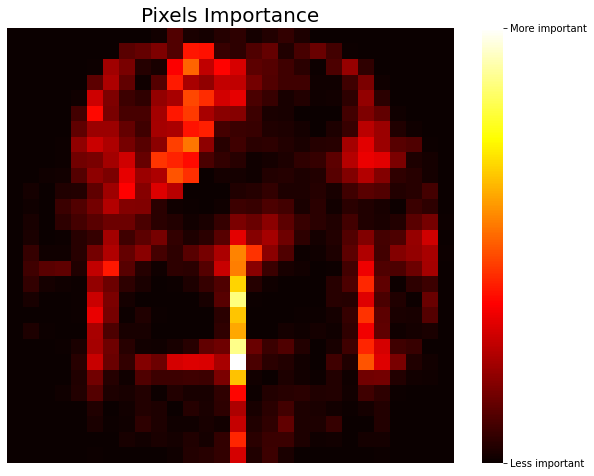

In [106]:
model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
model.fit(train_images, train_labels)

#shape of the dataset: (60000,728)
importances = model.feature_importances_
pixels = np.reshape(importances, (28, 28)) 

plt.figure(figsize=(10, 8))
plot = sns.heatmap(pixels, cmap=plt.cm.hot)
plt.xticks([], [])
plot.set_yticks([])
plot.set_yticks([], minor=True)
colorbar = plot.collections[0].colorbar
colorbar.set_ticks([0, max(importances)])
colorbar.set_ticklabels(['Less important', 'More important'])
plt.title('Pixels Importance', size=20)
plt.show()

## AdaBoost

In [100]:
from sklearn.ensemble import AdaBoostClassifier

adaBoost = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=200, algorithm="SAMME.R")

In [101]:
fit_predict("AdaBoost", adaBoost)

AdaBoost Accuracy: 79.15% 

AdaBoost Matrix:
 [[741   5  31  40   7   3 163   0   9   1]
 [  4 950   3  24   9   0   6   0   3   1]
 [ 23   0 660  21 155   1 128   0  10   2]
 [ 49  26  21 776  59   1  53   0  14   1]
 [  8   3 172  50 630   1 128   0   6   2]
 [  2   4   2   1   0 875   2  58  24  32]
 [135   6 129  34 104   4 563   1  22   2]
 [  1   0   1   0   0  46   0 883   4  65]
 [  7   2  14   5  11  12  21   5 919   4]
 [  1   0   0   0   0  19   1  57   4 918]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75      1000
           1       0.95      0.95      0.95      1000
           2       0.64      0.66      0.65      1000
           3       0.82      0.78      0.80      1000
           4       0.65      0.63      0.64      1000
           5       0.91      0.88      0.89      1000
           6       0.53      0.56      0.55      1000
           7       0.88      0.88      0.88      1000
          

In [102]:
fit_predict("AdaBoost", adaBoost, True)

AdaBoost Accuracy with PCA: 76.26% 

AdaBoost Matrix with PCA:
 [[700   8  31  55  14   6 169   0  17   0]
 [  7 936   6  31   9   0  10   0   1   0]
 [ 35   5 652  24 132   2 135   0  14   1]
 [ 47  42  26 769  59   3  45   0   9   0]
 [  7   3 175  43 638   0 123   1   9   1]
 [  3   0   1   5   2 827   2  92  16  52]
 [152   5 124  54 123   4 513   0  23   2]
 [  2   0   0   0   0  76   0 831   8  83]
 [  9   2  29   8  11  18  24  10 884   5]
 [  0   0   1   1   1  39   1  78   3 876]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71      1000
           1       0.94      0.94      0.94      1000
           2       0.62      0.65      0.64      1000
           3       0.78      0.77      0.77      1000
           4       0.65      0.64      0.64      1000
           5       0.85      0.83      0.84      1000
           6       0.50      0.51      0.51      1000
           7       0.82      0.83      0.83   